### Встреча 20 Января 2026

1. **Идея**: 4 поворота -> соединить в единое изображение
2. **Реализация**: Если нельзя разделить нулевую и первую частоты -> кидаем исключение
3. **Признак наложения**: есть интерферограмма (полосы) на восстановленном (после `ifft`) изображении
4. **DFT**: достраивает размер до степени двойки с заполнением нулями ост. части ($550 \rightarrow 1024$)


**TODO**:
1. Как сгладить границы эритроцитов
2. Проверить алгоритм для картинок с малым кол-вом полос (интерферограмм)

In [ ]:
!pip install -q scikit-image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def transform_luminance(img):
  coeffs = [0.299, 0.587, 0.114]
  return np.dot(img[..., :3], coeffs)

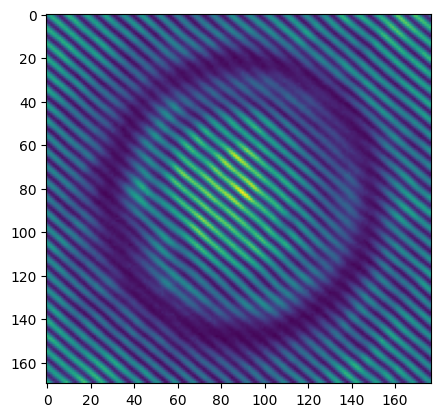

(170, 177)

In [ ]:
img = plt.imread("red-blood-cell-diffracted.png")
img = transform_luminance(img)

plt.imshow(img)
plt.show()

img.shape

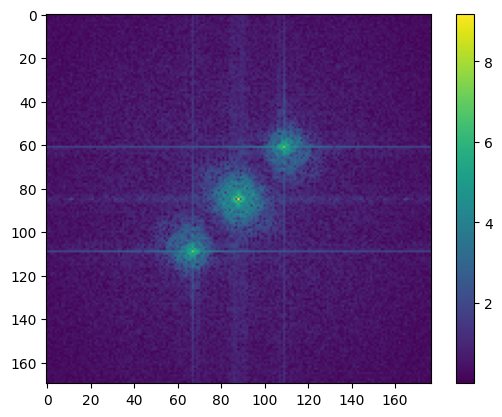

In [ ]:
F = np.fft.fft2(img)
F_shifted = np.fft.fftshift(F)


plt.imshow(np.log(np.abs(F_shifted) + 1))
plt.colorbar()
plt.show()

In [ ]:
def plot_amplitude(F, show=True):
  plt.imshow(np.log(np.abs(F) + 1))
  plt.colorbar()

  if show:
    plt.show()

In [ ]:
from scipy.ndimage import maximum_filter
from scipy.ndimage import maximum_position

In [ ]:
def erase_center(img, rel_radius=0.05):
  img = img.copy()
  n_rows, n_cols = img.shape

  y_center = n_rows // 2
  x_center = n_cols // 2
  radius = int(min(n_rows, n_cols) * rel_radius)
  ys, xs = np.mgrid[:n_rows, :n_cols]

  mask = ((xs - x_center) ** 2 + (ys - y_center) ** 2) <= radius ** 2
  img[mask] = np.mean(img)

  return img

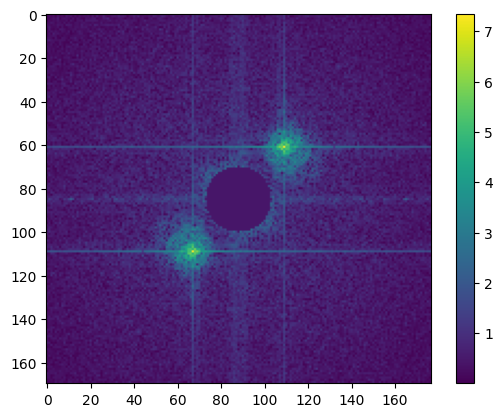

In [ ]:
F_erased = erase_center(F_shifted, rel_radius=0.09)

plot_amplitude(F_erased, show=False)
plt.show()

In [ ]:
from scipy.ndimage import maximum_position


def get_peak_position(img, rel_width=0.1):
  n_rows, n_cols = img.shape
  img = img.copy()

  y_center = n_rows // 2
  x_center = n_cols // 2

  width = int(min(n_rows, n_cols) * rel_width)

  img[y_center + width:] = 0
  img[:, :x_center + width] = 0

  return maximum_position(img)

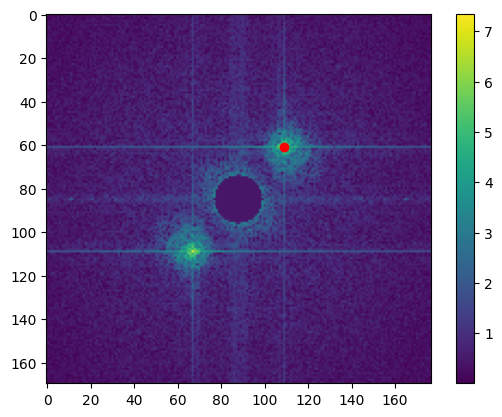

In [ ]:
F_erased = erase_center(F_shifted, rel_radius=0.07)
y_max, x_max = get_peak_position(F_erased)


plot_amplitude(F_erased, show=False)
plt.scatter([x_max], [y_max], color='red')
plt.show()

In [ ]:
def carrier_removal(F_amp, x_peak, y_peak):
  n_rows, n_cols = F_amp.shape

  dy = n_rows // 2 - y_peak
  dx = n_cols // 2 - x_peak

  F = np.roll(F_amp, (dy, dx), axis=(0, 1))
  return F

In [ ]:
def fill_not_center(fft_field, rel_radius=0.05):
  field = fft_field.copy()

  fill_value = 0.0
  n_rows, n_cols = F.shape

  y_center = n_rows // 2
  x_center = n_cols // 2

  radius = int(min(n_rows, n_cols) * rel_radius)

  ys, xs = np.mgrid[:n_rows, :n_cols]

  mask = ((xs - x_center) ** 2 + (ys - y_center) ** 2) > radius ** 2
  field[mask] = fill_value

  return field

In [ ]:
from scipy.ndimage import gaussian_filter


def transform(fft_field, rel_radius=0.08, sigma=1.0):
  F_amp = np.abs(fft_field)
  y_peak, x_peak = get_peak_position(F_amp)

  fft_field = carrier_removal(fft_field, x_peak, y_peak)
  fft_field = fill_not_center(fft_field, rel_radius=rel_radius)

  return fft_field

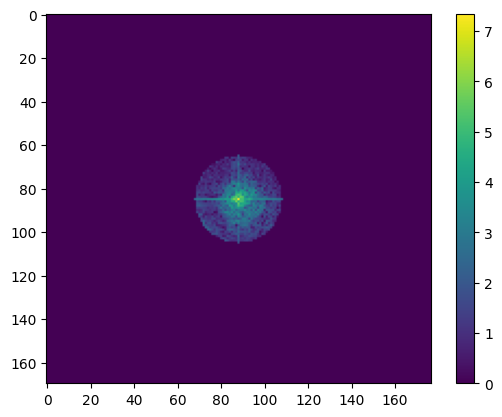

In [ ]:
# Визуализация области первой частоты
F = transform(F_shifted, rel_radius=0.12, sigma=1.0)

plot_amplitude(np.abs(F), show=False)
plt.show()


In [ ]:
u = np.fft.ifft2(np.fft.ifftshift(F))

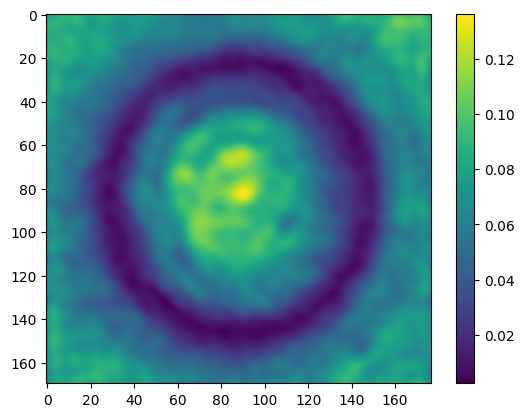

In [ ]:
plot_amplitude(np.abs(u))

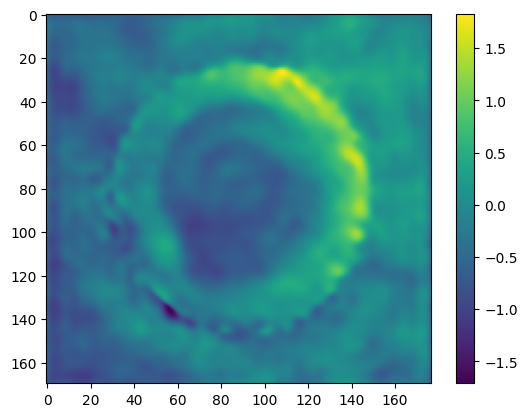

In [ ]:
plt.imshow(np.angle(u))
plt.colorbar()
# plt.savefig("fft3-ifft-phase.png")
plt.show()

### **Развёрнутая фаза**

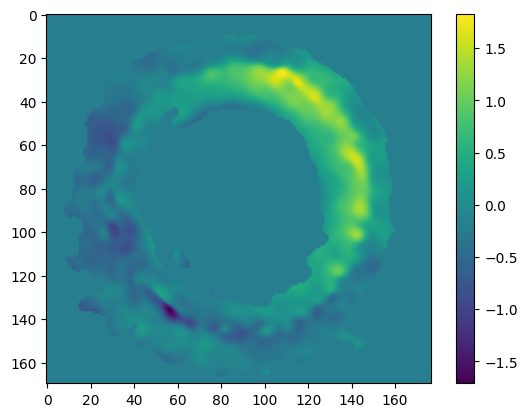

In [ ]:
from skimage.restoration import unwrap_phase

amplitude = np.abs(u)
phi_wrapped = np.angle(u)

p = np.percentile(amplitude, 40)
phi_wrapped[amplitude >= p] = np.median(phi_wrapped) # Комментарий от Натальи: зря наложил маску на фазу

phi_unwrapped = unwrap_phase(phi_wrapped)

plt.imshow(phi_unwrapped)
plt.colorbar()
plt.show()

### **Немного теории**

После того, как мы получили фазу: $\phi(x, y)$ мы можем сказать, что:

$$
h(x, y) = k \cdot \phi(x, y) ⇒ h(x, y) \sim \phi(x, y)
$$
где $h(x, y)$ - ширина эритроцита

### **3D-визуализация**

In [ ]:
from scipy.ndimage import uniform_filter

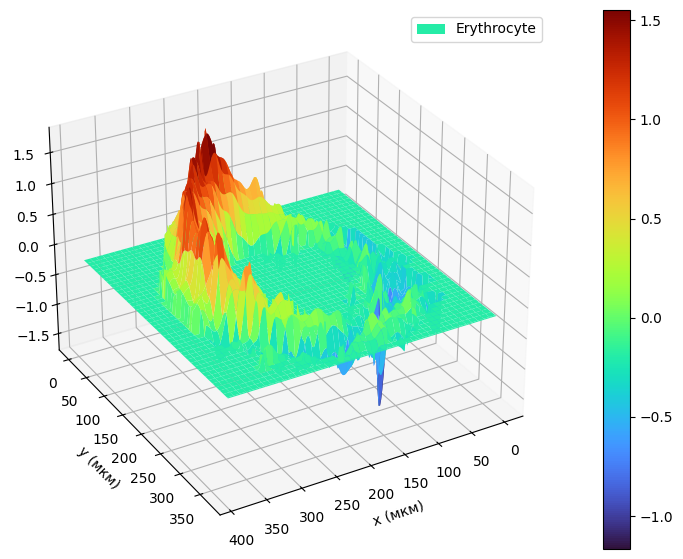

In [ ]:
size_pixel = 2.2
length_wave = 0.65

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')

n_rows, n_cols = phi_unwrapped.shape

Y, X = np.mgrid[:n_rows, :n_cols]
Y, X = size_pixel * Y, size_pixel * X

Z = phi_unwrapped.copy()

ax.view_init(elev=30, azim=60)
surf = ax.plot_surface(
    X, Y, Z, label='Erythrocyte', cmap='turbo'
)
ax.legend()

ax.set_xlabel("x (мкм)")
ax.set_ylabel("y (мкм)")

fig.colorbar(surf)
plt.show()

## **Реализация единого пайплайна**

In [ ]:
from scipy.ndimage import median_filter
from scipy.ndimage import uniform_filter
from scipy.ndimage import gaussian_filter

from scipy.ndimage import maximum_position

In [ ]:
def transform_luminance(img):
  return np.dot(img[..., :3], [0.299, 0.587, 0.114])

In [ ]:
def find_peak_position(img, rel_width=0.1):
  n_rows, n_cols = img.shape
  img = img.copy()

  y_center = n_rows // 2
  x_center = n_cols // 2

  width = int(min(n_rows, n_cols) * rel_width)
  img[y_center + width:] = 0
  img[:, :x_center + width] = 0

  return maximum_position(img)

In [ ]:
def shift_peak(F, x_peak, y_peak):
  n_rows, n_cols = F.shape

  dy = n_rows // 2 - y_peak
  dx = n_cols // 2 - x_peak

  F = np.roll(F, (dy, dx), axis=(0, 1))
  return F

In [ ]:
def remove_carrier(fft_field, rel_radius=0.05):
  field = fft_field.copy()

  n_rows, n_cols = F.shape

  y_center = n_rows // 2
  x_center = n_cols // 2

  radius = int(min(n_rows, n_cols) * rel_radius)

  ys, xs = np.mgrid[:n_rows, :n_cols]

  fill_value = 0.0
  mask = ((xs - x_center) ** 2 + (ys - y_center) ** 2) > radius ** 2
  field[mask] = fill_value

  return field

In [ ]:
def transform(fft_field, rel_radius=0.08, sigma=1.0):
  F_amp = np.abs(fft_field)
  y_peak, x_peak = get_peak_position(F_amp)

  fft_field = carrier_removal(fft_field, x_peak, y_peak)
  fft_field = fill_not_center(fft_field, rel_radius=rel_radius)

  return fft_field

In [ ]:
from skimage.restoration import unwrap_phase

In [ ]:
def get_unwrap_phase_mask(A, phi):
  """
  Получить маску, где будет проведена развётка фазы
  """
  thr = np.percentile(A, 30)
  return A <= thr

In [ ]:
def transform_blood_cell_2d_image(cell_image, rel_width=0.1, rel_radius=0.1):
  """
  Преобразование двумерного изображения эритроцита, которое позволяет
  получить трёхмерное изображение
  """
  # Шаг 0. Приводим картинку к чёрно-белому формару
  img = transform_luminance(cell_image)

  # Шаг 1. Преобразование Фурье
  F = np.fft.fft2(img)
  F = np.fft.fftshift(F)

  # Шаг 2. Оставляем только 1-ую частоту
  A = np.abs(F)
  y_peak, x_peak = find_peak_position(A, rel_width=rel_width)
  F_new = shift_peak(F, x_peak, y_peak)
  F_new = remove_carrier(F_new, rel_radius=rel_radius)

  # Шаг 3. Обратное преобразование Фурье
  F_new = np.fft.ifft2(np.fft.ifftshift(F_new))

  # Шаг 4. Раз
  phi = np.angle(F_new)

  # mask
  A = np.abs(F_new)
  mask = get_unwrap_phase_mask(A, phi)
  phi[~mask] = 0.0
  phi_uw = unwrap_phase(phi)

  return A, phi_uw

In [ ]:
img = plt.imread("red-blood-cell-diffracted.png")

A, phi_uw = transform_blood_cell_2d_image(img)

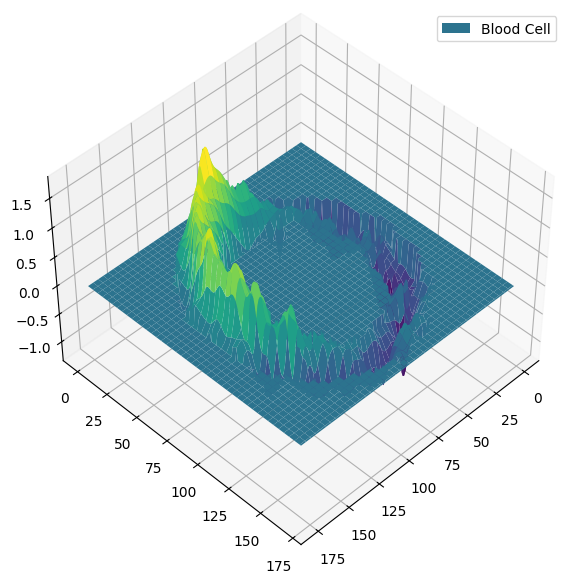

In [ ]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')

n_rows, n_cols = phi_uw.shape
Y, X = np.mgrid[:n_rows, :n_cols]
Z = phi_uw.copy()

ax.view_init(elev=45, azim=45)
ax.plot_surface(
    X, Y, Z, label='Blood Cell', cmap='viridis'
)
ax.legend()

plt.show()

### **Единый пайплайн с учётом правок**
Ключевые шаги:
1. Нахождение частоты первого порядка
2. Сдвигаем частоту в центр + "удаляем" всё что не в центре
3. Получаем и разворачиваем фазу $→$ строим картиночки

Основная задача: исправление развёртки на границе эритроцита

In [36]:
!pip install -q scikit-image

In [37]:
import numpy as np
from scipy.ndimage import maximum_position
from skimage.restoration import unwrap_phase

import matplotlib.pyplot as plt

In [40]:
def image_to_grey(image: np.ndarray):
  """
  Перевести изображение в 2D-массив (чёрно-белое)
  """
  assert image.ndim == 3
  return np.dot(image[..., :3], [0.299, 0.587, 0.114])

In [110]:
def first_order_position(F: np.ndarray, rel_radius: float = 0.05):
  F = F.copy()

  n_rows, n_cols = F.shape
  y_center, x_center = n_rows // 2, n_cols // 2

  abs_radius = int(min(n_rows, n_cols) * rel_radius)
  ys, xs = np.mgrid[:n_rows, :n_cols]

  mask = ((xs - x_center) ** 2 + (ys - y_center) ** 2) <= abs_radius ** 2
  F[:, :x_center] = 0.0
  F[y_center:, :] = 0.0
  F[mask] = 0.0

  max_pos = maximum_position(F)
  return max_pos

In [20]:
def move_position(F, position):
  F = F.copy()
  n_rows, n_cols = F.shape

  y_center, x_center = n_rows // 2, n_cols // 2
  y_peak, x_peak = position

  dy = y_center - y_peak
  dx = x_center - x_peak

  F = np.roll(F, (dy, dx), axis=(0, 1))
  return F

In [21]:
def remove_carrier(F, rel_radius=0.05):
  F = F.copy()

  n_rows, n_cols = F.shape
  y_center, x_center = n_rows // 2, n_cols // 2

  abs_radius = int(min(n_rows, n_cols) * rel_radius)
  ys, xs = np.mgrid[:n_rows, :n_cols]

  mask = ((xs - x_center) ** 2 + (ys - y_center) ** 2) > (abs_radius ** 2)
  F[mask] = 0.0
  return F

In [137]:
def pipeline(image, fo_rel_radius=0.05, rc_rel_radius=0.08):
  """
  Весь пайплайн алгоритма 2FFT
  """
  image = image_to_grey(image)

  F = np.fft.fft2(image)
  F = np.fft.fftshift(F)

  peak = first_order_position(F, rel_radius=fo_rel_radius)
  F = move_position(F, peak)
  F = remove_carrier(F, rel_radius=rc_rel_radius)

  F_new = np.fft.ifftshift(F)
  F_new = np.fft.ifft2(F_new)

  A_new, phi_new = np.abs(F_new), np.angle(F_new)
  phi_new = unwrap_phase(phi_new)

  return A_new, phi_new

In [79]:
def find_pixel_size(pixel_size, scope):
  """
  Размер пикселя финального изображения
  """
  return pixel_size / scope

In [81]:
def plot_amplitude(F, peak=None, show=True, **kwargs):
  image = np.log(np.abs(F) + 1.0)

  plt.imshow(image, **kwargs)
  plt.colorbar()

  if peak is not None:
    idx_y, idx_x = peak
    plt.scatter([idx_x], [idx_y], color='red')

  if show:
    plt.show()

In [133]:
def plot_3d_phase(A, phi, pixel_size, wave_length, show=False, cmap='viridis'):
  n_rows, n_cols = A.shape

  Y, X = np.mgrid[:n_rows, :n_cols]
  X = pixel_size * X
  Y = pixel_size * Y
  Z = wave_length * phi / (2 * np.pi)

  fig = plt.figure(figsize=(14, 7))
  ax = fig.add_subplot(111, projection='3d')

  ax.view_init(elev=45, azim=45)
  surf = ax.plot_surface(X, Y, Z, label='Blood Cell', cmap=cmap)
  fig.colorbar(surf)

  ax.legend()
  ax.set_xlabel("длина (мкм)")
  ax.set_ylabel("ширина (мкм)")

  if show:
    plt.show()

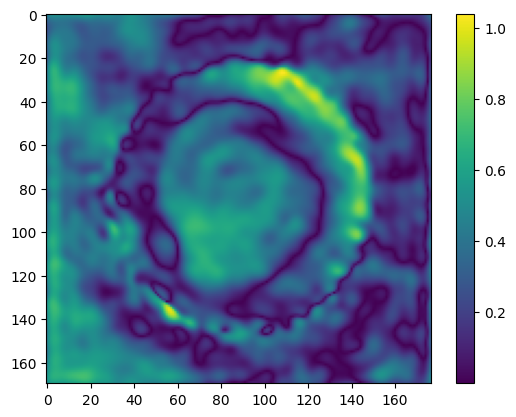

In [166]:
image = plt.imread("red-blood-cell-diffracted.png")
image = image_to_grey(image)

F = np.fft.fft2(image)
F = np.fft.fftshift(F)

peak = first_order_position(F)

F = move_position(F, peak)
F = remove_carrier(F, 0.12)

F_new = np.fft.ifftshift(F)
F_new = np.fft.ifft2(F_new)

A_new, phi_new = np.abs(F_new), np.angle(F_new)
phi_new = unwrap_phase(phi_new)

plot_amplitude(phi_new, peak=None)

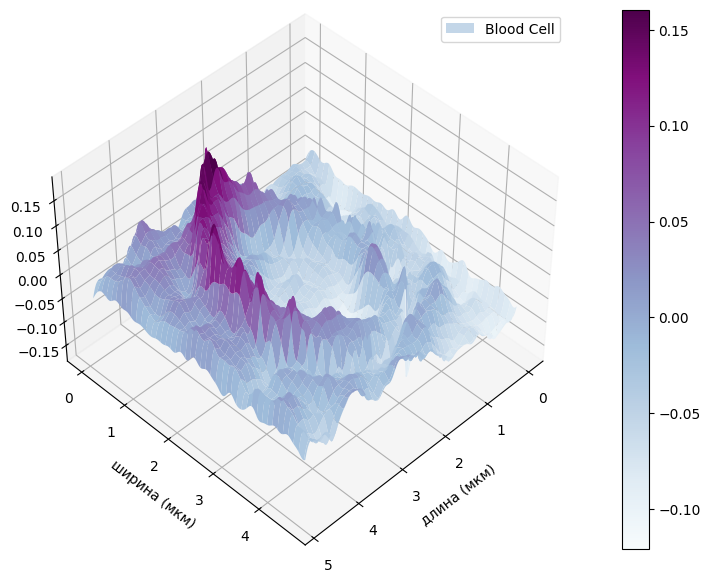

In [140]:
wave_length = 0.65
scope = 80.0
pixel_size = 2.2 / scope

plot_3d_phase(
    A_new, phi_new,
    pixel_size=pixel_size, wave_length=wave_length,
    cmap='BuPu'
)

#### **Изображение 1B**

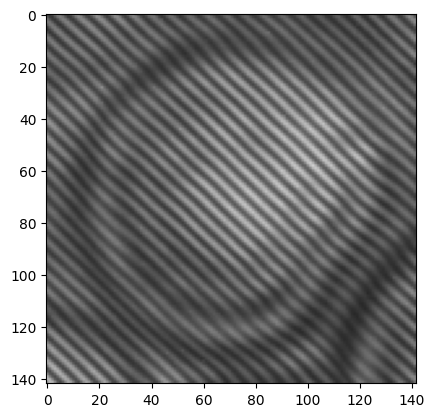

In [148]:
img = plt.imread("img-1.bmp")

plt.imshow(img)
plt.show()

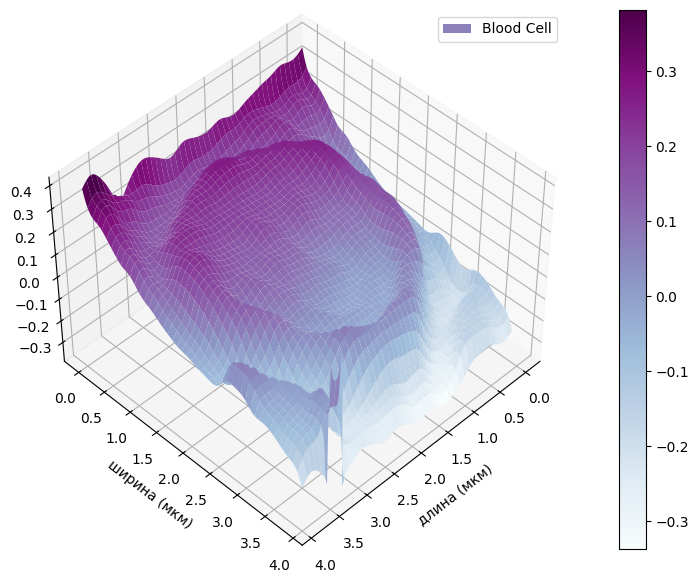

In [149]:
A, phi = pipeline(img, fo_rel_radius=0.07)
plot_3d_phase(A, phi, pixel_size, wave_length, show=False, cmap='BuPu')

#### **Изображение 16**

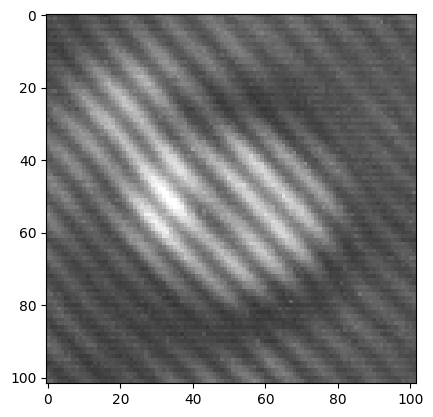

In [150]:
img = plt.imread("img-16-a.bmp")

plt.imshow(img)
plt.show()

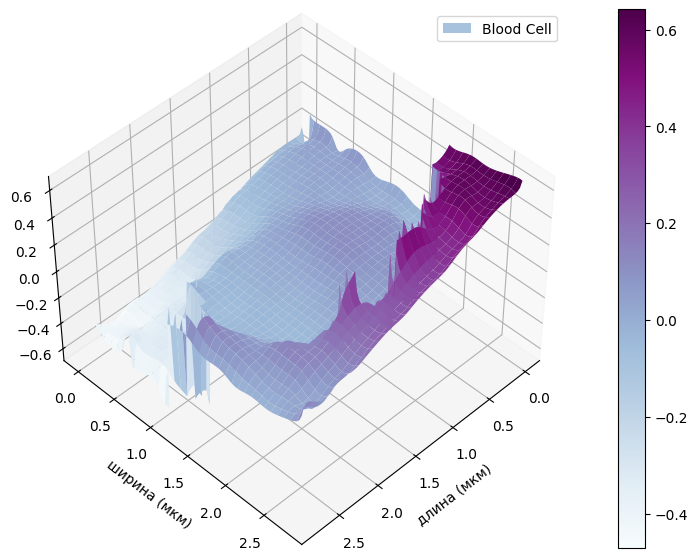

In [151]:
A, phi = pipeline(img, fo_rel_radius=0.07)
plot_3d_phase(A, phi, pixel_size, wave_length, show=False, cmap='BuPu', save=False)

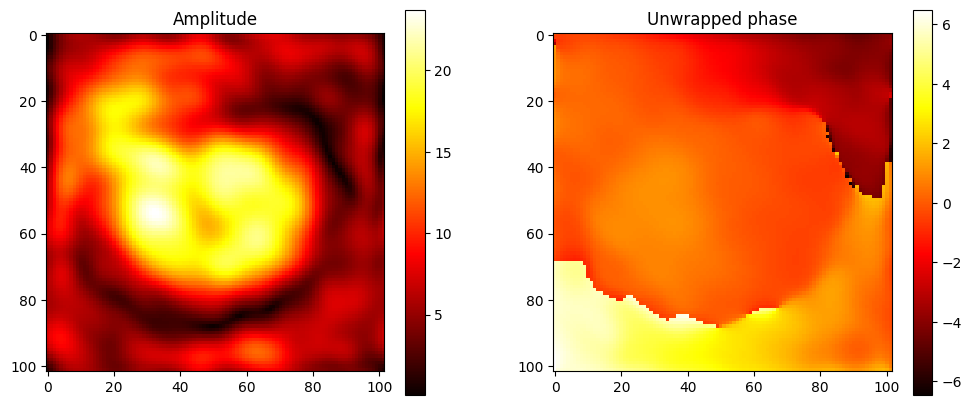

In [165]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im_a = axes[0].imshow(A, cmap='hot')
plt.colorbar(im_a, ax=axes[0])
axes[0].set_title("Amplitude")

im_p = axes[1].imshow(phi, cmap='hot')
plt.colorbar(im_p, ax=axes[1])
axes[1].set_title("Unwrapped phase")

plt.show()